In [1]:
%run 0.1-data-import.ipynb

## 2.0 Model Development

#### 2.0.1 Data Cleaning

In [2]:
# Remove the unusual ups and downs found during EDA
data = data[~((data['family'].isin(['BEVERAGES', 'PRODUCE']) & (data['date'] <= '2015-08-01')))]
data = data[~((data['family'].isin(['POULTRY', 'DAIRY']) & (data['date'] <= '2013-12-01')))]

#### 2.0.2 Preprocessing

In [3]:
# Create the unique identifier for time series
group_by = ['store_nbr', 'family']
data['id'] = data[group_by].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# Define categorical columns
categorical_cols = ['id', 'family', 'city', 'state', 'type', 'cluster']
label_encoder = preprocessing.LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

#### 2.0.3 Feature Engineering

In [4]:
forecast_horizon = 28

##### 2.0.3.1 Date Features

In [5]:
data['year'] = data['date'].dt.year
data['quarter'] = data['date'].dt.quarter
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.week
data['day_of_week'] = data['date'].dt.dayofweek 
data['day_of_month'] = data['date'].dt.day  
data['day_of_year'] = data['date'].dt.dayofyear

data['is_weekend'] = data['day_of_week'] >= 5
data['is_month_end'] = data['date'].dt.is_month_end

# Wages in the public sector are paid every two weeks on the 15th
data['is_payroll'] = data['day_of_month'] == 15

# A magnitude 7.8 earthquake struck Ecuador on April 16, 2016
earthquake_date = pd.to_datetime('2016-04-16')
start_of_week = earthquake_date - pd.Timedelta(days=earthquake_date.weekday())
end_of_week = start_of_week + pd.Timedelta(days=6)
data['is_earthquake'] = data['date'].between(start_of_week, end_of_week)

# Convert boolean columns to 1s and 0s
data['is_weekend'] = data['is_weekend'].astype(int)
data['is_month_end'] = data['is_month_end'].astype(int)
data['is_payroll'] = data['is_payroll'].astype(int)
data['is_earthquake'] = data['is_earthquake'].astype(int)

##### 2.0.3.2 Statistical Features

In [6]:
# Set some features due to easiness
feature_extraction_settings = {
    'sales': {
        'mean': None,
        'variance': None,
        'standard_deviation': None,
        'maximum': None,
        'minimum': None,
        'skewness': None,
        'kurtosis': None,
        'linear_trend': [
            {"attr": "pvalue"},  
            {"attr": "rvalue"},  
            {"attr": "intercept"},  
            {"attr": "slope"},
        ]
    }
}

statistical_features = extract_features(data[['id', 'date', 'sales']], 
                                        column_id='id', 
                                        column_sort='date', 
                                        kind_to_fc_parameters=feature_extraction_settings).reset_index()
statistical_features = statistical_features.rename(columns={'index': 'id'})


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 13.31it/s]


##### 2.0.3.3 Lag Features

In [7]:
nonrecursive_lags = [1, 6, 21, 43, 66, 101]
lags = [forecast_horizon + lag for lag in nonrecursive_lags]

lag_it = LagFeatures(periods=lags, drop_original=True)
transformed_groups = []

# Group the data by 'id' and apply lag transformation to each group
for _, group in data.groupby('id'):
    transformed_group = lag_it.fit_transform(group[['sales']])
    transformed_groups.append(transformed_group)

lagged_features = pd.concat(transformed_groups)

##### 2.0.3.4 Window Features

In [8]:
rolling_window = [5, 12, 33, 42, 91]
windows =  [forecast_horizon + window for window in rolling_window]

roll_it = WindowFeatures(window=windows, functions=['mean', 'max', 'std'],  drop_original=True)
transformed_groups = []

for _, group in data.groupby('id'):
    transformed_group = roll_it.fit_transform(group[['sales']])
    transformed_groups.append(transformed_group)

window_features = pd.concat(transformed_groups)


In [9]:
# Merge calculated features
data = data.merge(statistical_features, on='id', how='left')
data = data.merge(lagged_features, left_index=True, right_index=True,  how='left')
data = data.merge(window_features, left_index=True, right_index=True, how='left')

data.dropna(inplace=True)

#### 2.0.4 Data Split

In [10]:
# Split the dataset into training and validation sets
cutoff_date = data["date"].max() - pd.to_timedelta(forecast_horizon, unit='D')

train = data[data['date'] <= cutoff_date].copy()
valid = data[data['date'] > cutoff_date].copy()

#### 2.0.3 Model Building

In [11]:
static_cov_cols = ['city', 'state', 'type', 'cluster']
future_cov_cols = list(set(train.columns) - set(static_cov_cols) - set(['id', 'date', 'sales']))

y_train = TimeSeries.from_group_dataframe(train,
                                          group_cols='id',
                                          time_col='date',
                                          static_cols=static_cov_cols,
                                          value_cols=['sales'],
                                          fill_missing_dates=True,
                                          freq='D',
                                          fillna_value=0)

future_cov_train = TimeSeries.from_group_dataframe(train,
                                          group_cols='id',
                                          time_col='date',
                                          static_cols=static_cov_cols,
                                          value_cols=future_cov_cols,
                                          fill_missing_dates=True,
                                          freq='D',
                                          fillna_value=0)

y_valid = TimeSeries.from_group_dataframe(valid,
                                          group_cols='id',
                                          time_col='date',
                                          static_cols=static_cov_cols,
                                          value_cols=['sales'],
                                          fill_missing_dates=True,
                                          freq='D',
                                          fillna_value=0)

future_cov_valid = TimeSeries.from_group_dataframe(valid,
                                          group_cols='id',
                                          time_col='date',
                                          static_cols=static_cov_cols,
                                          value_cols=future_cov_cols,
                                          fill_missing_dates=True,
                                          freq='D',
                                          fillna_value=0)


In [12]:
target_lags = [-1, -2, -12]

model = LightGBMModel(
    lags=target_lags,
    lags_future_covariates=[0],
    use_static_covariates=True,
    verbose=-1
)

model.fit(series=y_train, 
          future_covariates=future_cov_train)

y_pred = model.predict(n=forecast_horizon, 
                       series=y_train,
                       future_covariates=future_cov_valid)

In [13]:
history_dates = y_train[1].time_index[1260:1660]
history_values = y_train[1].values()[1260:1660]

# Actual (from y_valid)
actual_dates = y_valid[1].time_index
actual_values = y_valid[1].values()

# Forecast (from y_pred)
forecast_dates = y_pred[1].time_index
forecast_values = y_pred[1].values()

# Initialize figure with subplots
fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(go.Scatter(x=history_dates, y=history_values.flatten(), name="History"), secondary_y=False)
fig.add_trace(go.Scatter(x=actual_dates, y=actual_values.flatten(), name="Actual"), secondary_y=False)
fig.add_trace(go.Scatter(x=forecast_dates, y=forecast_values.flatten(), name="Forecast"), secondary_y=False)
fig.update_layout(title_text="An example Family-Store")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Value", secondary_y=False)

fig.show()

#### 2.0.4 Model Evaluation

In [221]:
mapes = [mape(y_valid[i], y_pred[i]) for i in range(len(y_valid))]
rmses = [rmse(y_valid[i], y_pred[i]) for i in range(len(y_valid))]

# Calculate average MAPE and RMSE across all series
average_mape = sum(mapes) / len(mapes)
average_rmse = sum(rmses) / len(rmses)

print(f"Average MAPE: {average_mape:.2f}%")
print(f"Average RMSE: {average_rmse}")

Average MAPE: 21.13%
Average RMSE: 263.7309797134101


#### 2.0.4.1 Backtesting

In [234]:
backtest_results = model.historical_forecasts(
    series=y_train,
    start=pd.Timestamp('2017-01-01'),
    future_covariates=future_cov_train,
    retrain=False,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon // 2,
    verbose=-1
)

backtest_rmses = [rmse(y_train[i].slice_intersect(backtest_results[i]), backtest_results[i]) for i in range(len(y_train))]
# Calculate the average RMSE across all series
average_backtest_rmse = np.mean(backtest_rmses)
print(f"Average Backtest RMSE: {average_backtest_rmse}")

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/540 [00:00<?, ?it/s]

Average Backtest RMSE: 280.535648767818


##### 2.0.4.2 Feature Importance

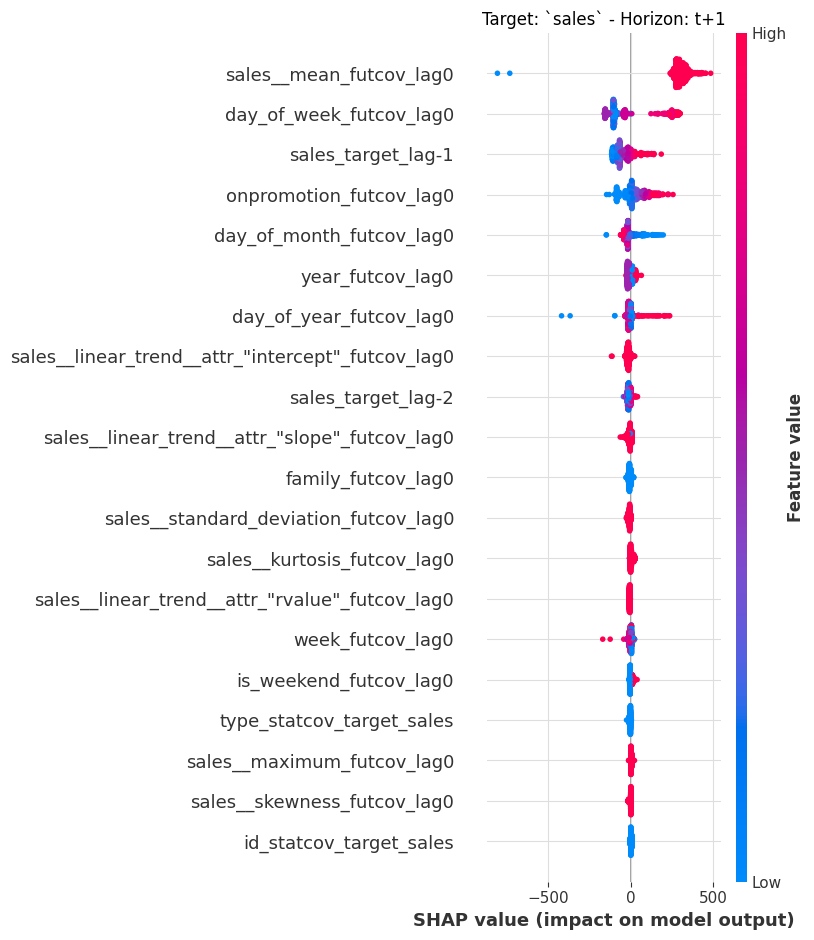

In [201]:
# Example importance for one series
shap_explain = ShapExplainer(model, 
                             background_series=y_train[0], 
                             background_future_covariates=future_cov_train[0])
results = shap_explain.explain()
shap_explain.summary_plot();

#### 2.0.4 Model Tune

<div class="alert alert-block alert-warning">

While Optuna offers advanced hyperparameter optimization capabilities and could significantly enhance the model tuning process by exploring a broader and potentially more optimal parameter space, its integration is being skipped for the moment. This decision allows the focus to remain on utilizing Darts' built-in tuning functionalities, which provide a straightforward and accessible approach for model optimization within the existing workflow.

</div>